In [1]:
import pyspark
import os
import sys
from pyspark import SparkContext
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "16g").appName('chapter_8').getOrCreate()

/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
stocks = spark.read.csv(["stocks/ABAX.csv","stocks/AAME.csv","stocks/AEPI.csv"], header='true', inferSchema='true')
#stocks=spark.read.format("csv").option("inferSchema","true").option("header","true").load('C:/Users/HP/Desktop/aas-pyspark-edition/data/stocksA/AAIT.csv').load('C:/Users/HP/Desktop/aas-pyspark-edition/data/stocksA/→AAME.csv')
stocks.show(2)

+---------+-----+-----+-----+-----+------+
|     Date| Open| High|  Low|Close|Volume|
+---------+-----+-----+-----+-----+------+
|31-Dec-13|52.94|54.37|52.25|52.83| 79429|
|30-Dec-13|50.36|54.10|50.36|52.95|131095|
+---------+-----+-----+-----+-----+------+
only showing top 2 rows



In [6]:
from pyspark.sql import functions as fun
stocks = stocks.withColumn("Symbol", fun.input_file_name()).withColumn("Symbol",fun.element_at(fun.split("Symbol", "/"), -1)).withColumn("Symbol",fun.element_at(fun.split("Symbol", "\."), 1))
stocks.show(2)

+---------+-----+-----+-----+-----+------+------+
|     Date| Open| High|  Low|Close|Volume|Symbol|
+---------+-----+-----+-----+-----+------+------+
|31-Dec-13|52.94|54.37|52.25|52.83| 79429|  AEPI|
|30-Dec-13|50.36|54.10|50.36|52.95|131095|  AEPI|
+---------+-----+-----+-----+-----+------+------+
only showing top 2 rows



In [9]:
factors = spark.read.csv(["stocks/ABAX.csv","stocks/AAME.csv","stocks/AEPI.csv"], header='true', inferSchema='true')
factors = factors.withColumn("Symbol", fun.input_file_name()).withColumn("Symbol",fun.element_at(fun.split("Symbol", "/"), -1)).withColumn("Symbol",fun.element_at(fun.split("Symbol", "\."), 1))

In [10]:
from pyspark.sql import Window
stocks = stocks.withColumn('count', fun.count('Symbol').over(Window.partitionBy('Symbol'))).filter(fun.col('count') > 260*5 + 10)

In [11]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [12]:
stocks = stocks.withColumn('Date',fun.to_date(fun.to_timestamp(fun.col('Date'),'dd-MMM-yy')))
stocks.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- count: long (nullable = false)



In [13]:
from datetime import datetime
stocks = stocks.filter(fun.col('Date') >= datetime(2009, 10, 23)).filter(fun.col('Date') <= datetime(2014, 10, 23))

In [14]:
factors = factors.withColumn('Date',fun.to_date(fun.to_timestamp(fun.col('Date'),'dd-MMM-yy')))
factors = factors.filter(fun.col('Date') >= datetime(2009, 10, 23)).filter(fun.col('Date') <= datetime(2014, 10, 23))

In [15]:
stocks_pd_df = stocks.toPandas()
factors_pd_df = factors.toPandas()
factors_pd_df.head(5)

,Date,Open,High,Low,Close,Volume,Symbol
0,2013-12-31,52.94,54.37,52.25,52.83,79429,AEPI
1,2013-12-30,50.36,54.10,50.36,52.95,131095,AEPI
2,2013-12-27,50.38,50.80,49.67,50.52,54354,AEPI
3,2013-12-26,50.50,51.19,49.67,50.00,74414,AEPI
4,2013-12-24,49.85,50.60,49.66,49.99,36872,AEPI


In [16]:
n_steps = 10
def my_fun(x):
    return ((x.iloc[-1] - x.iloc[0]) / x.iloc[0])
stock_returns = stocks_pd_df.groupby('Symbol').Close.rolling(window=n_steps).apply(my_fun)
factors_returns = factors_pd_df.groupby('Symbol').Close.rolling(window=n_steps).apply(my_fun)
stock_returns = stock_returns.reset_index().sort_values('level_1').reset_index()
factors_returns = factors_returns.reset_index().sort_values('level_1').reset_index()

In [17]:
# Create combined stocks DF
stocks_pd_df_with_returns = stocks_pd_df.assign(stock_returns = stock_returns['Close'])
# Create combined factors DF
factors_pd_df_with_returns = factors_pd_df.assign(factors_returns = factors_returns['Close'],
factors_returns_squared = factors_returns['Close']**2)
factors_pd_df_with_returns = factors_pd_df_with_returns.pivot(index='Date',columns='Symbol',values=['factors_returns', 'factors_returns_squared'])
factors_pd_df_with_returns.columns = factors_pd_df_with_returns.columns.to_series().str.join('_').reset_index()[0]
factors_pd_df_with_returns = factors_pd_df_with_returns.reset_index()
print(factors_pd_df_with_returns.head(1))

0        Date  factors_returns_AAME  factors_returns_ABAX  \
0  2009-10-23              0.111111               0.10064   

0  factors_returns_AEPI  factors_returns_squared_AAME  \
0              0.097994                      0.012346   

0  factors_returns_squared_ABAX  factors_returns_squared_AEPI  
0                      0.010128                      0.009603  


In [18]:
print(factors_pd_df_with_returns.columns)

Index(['Date', 'factors_returns_AAME', 'factors_returns_ABAX',
       'factors_returns_AEPI', 'factors_returns_squared_AAME',
       'factors_returns_squared_ABAX', 'factors_returns_squared_AEPI'],
      dtype='object', name=0)


In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
# For each stock, create input DF for linear regression training
stocks_factors_combined_df = pd.merge(stocks_pd_df_with_returns,factors_pd_df_with_returns,how="left", on="Date")
feature_columns = list(stocks_factors_combined_df.columns[-6:])
with pd.option_context('mode.use_inf_as_na', True):
    stocks_factors_combined_df = stocks_factors_combined_df.dropna(subset=feature_columns + ['stock_returns'])
    
def find_ols_coef(df):
    y = df[['stock_returns']].values
    X = df[feature_columns]
    regr = LinearRegression()
    regr_output = regr.fit(X, y)
    return list(df[['Symbol']].values[0]) + list(regr_output.coef_[0])

coefs_per_stock = stocks_factors_combined_df.groupby('Symbol').apply(find_ols_coef)
coefs_per_stock = pd.DataFrame(coefs_per_stock).reset_index()
coefs_per_stock.columns = ['symbol', 'factor_coef_list']
coefs_per_stock = pd.DataFrame(coefs_per_stock.factor_coef_list.tolist(),index=coefs_per_stock.index,columns = ['Symbol'] + feature_columns)
coefs_per_stock

/home/lplab/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/lplab/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True

,Symbol,factors_returns_AAME,factors_returns_ABAX,factors_returns_AEPI,factors_returns_squared_AAME,factors_returns_squared_ABAX,factors_returns_squared_AEPI
0,AAME,1.000000e+00,-1.240376e-15,9.220346e-16,1.607635e-16,-9.631756e-17,8.117732e-17
1,ABAX,5.729698e-16,1.000000e+00,-4.242853e-16,5.503443e-19,-3.607932e-17,2.408654e-17
2,AEPI,-3.140315e-16,9.080787e-17,1.000000e+00,-9.744513e-17,7.967819e-17,-7.846324e-17


In [20]:
samples = factors_returns.loc[factors_returns.Symbol == factors_returns.Symbol.unique()[0]]['Close']
samples.plot.kde()

In [21]:
f_1 = factors_returns.loc[factors_returns.Symbol == factors_returns.Symbol.unique()[0]]['Close']
f_2 = factors_returns.loc[factors_returns.Symbol == factors_returns.Symbol.unique()[1]]['Close']
f_3 = factors_returns.loc[factors_returns.Symbol == factors_returns.Symbol.unique()[2]]['Close']

print(f_1.size,len(f_2),f_3.size)
pd.DataFrame({'f1': list(f_1)[1:1040], 'f2': list(f_2)[1:1040], 'f3':list(f_3)}).corr()

1053 1053 1039


,f1,f2,f3
f1,1.000000,0.275057,-0.015415
f2,0.275057,1.000000,0.031370
f3,-0.015415,0.031370,1.000000


In [22]:
factors_returns_cov = pd.DataFrame({'f1': list(f_1)[1:1040],'f2': list(f_2)[1:1040],'f3': list(f_3)}).cov().to_numpy()
factors_returns_mean = pd.DataFrame({'f1': list(f_1)[1:1040],'f2': list(f_2)[1:1040],'f3': list(f_3)}).mean()

In [23]:
from numpy.random import multivariate_normal
multivariate_normal(factors_returns_mean, factors_returns_cov)

array([ 0.06435377,  0.02621194, -0.06292533])

In [24]:
b_coefs_per_stock = spark.sparkContext.broadcast(coefs_per_stock)
b_feature_columns = spark.sparkContext.broadcast(feature_columns)
b_factors_returns_mean = spark.sparkContext.broadcast(factors_returns_mean)
b_factors_returns_cov = spark.sparkContext.broadcast(factors_returns_cov)

In [25]:
from pyspark.sql.types import IntegerType
parallelism = 1000
num_trials = 1000000
base_seed = 1496
seeds = [b for b in range(base_seed,
base_seed + parallelism)]
seedsDF = spark.createDataFrame(seeds, IntegerType())
seedsDF = seedsDF.repartition(parallelism)

In [26]:
import random
from numpy.random import seed
from pyspark.sql.types import LongType, ArrayType, DoubleType
from pyspark.sql.functions import udf

def calculate_trial_return(x):
    # return x
    trial_return_list = []
    for i in range(int(num_trials/parallelism)):
        random_int = random.randint(0, num_trials*num_trials)
        seed(x)
        random_factors = multivariate_normal(b_factors_returns_mean.value,b_factors_returns_cov.value)
        coefs_per_stock_df = b_coefs_per_stock.value
        returns_per_stock = (coefs_per_stock_df[b_feature_columns.value] * (list(random_factors) + list(random_factors**2)))
        trial_return_list.append(float(returns_per_stock.sum(axis=1).sum()/b_coefs_per_stock.value.size))
    return trial_return_list
udf_return = udf(calculate_trial_return, ArrayType(DoubleType()))

In [27]:
from pyspark.sql.functions import col, explode
trials = seedsDF.withColumn("trial_return", udf_return(col("value")))
trials = trials.select('value', explode('trial_return').alias('trial_return'))
trials.cache()

DataFrame[value: int, trial_return: double]

In [28]:
trials.approxQuantile('trial_return', [0.05], 0.0)

[-0.010751520678973657]

In [29]:
trials.orderBy(col('trial_return').asc()).limit(int(trials.count()/20)).agg(fun.avg(col("trial_return"))).show()

+--------------------+
|   avg(trial_return)|
+--------------------+
|-0.01328224130003...|
+--------------------+



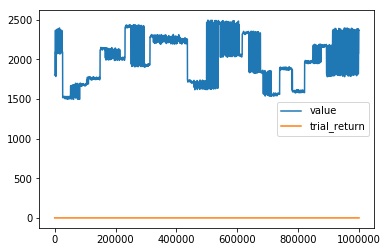

In [30]:
import pandas
mytrials=trials.toPandas()
mytrials.plot.line()